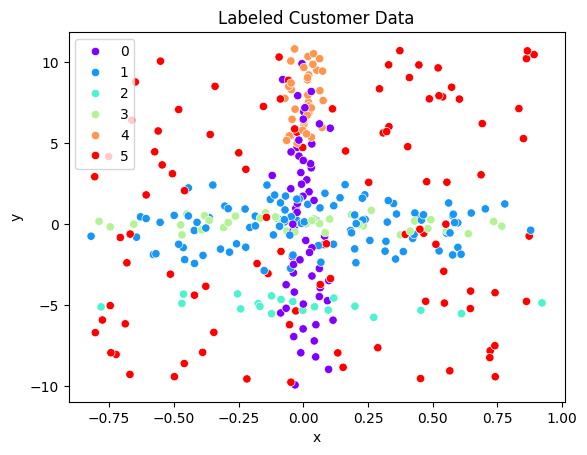

In [33]:
###··· A3 DATASET ···### 
# Part 1: Selecting and analyzing the dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode

#Load the dataset
dataset = pd.read_csv("A3-data.txt", header=0, na_values = "?", sep=",")
x = dataset[['x', 'y', 'z', 't']]
y = dataset[['class']]-1        # -1 to fit range between [0,5]

sns.scatterplot(x='x', 
                y='y',
                data=x, 
                hue=y['class'].values.ravel(),
                palette="rainbow").set_title('Labeled Customer Data')

# ------------------------------------------------------------------------------ #
def plot_correlation_matrix(principal_components, predicted_labels, k_values):
    label_mapping = {}
    for i in range(k_values):
        # Find the most common true label for each cluster label
        most_common = mode(y[predicted_labels == i])[0][0]    
        label_mapping[i] = most_common
    # Apply the mapping to the predicted labels
    predicted_labels_mapped = [label_mapping[label] for label in predicted_labels]

    sns.scatterplot(x='PC1', 
                    y='PC3', 
                    data=principal_components, 
                    hue=predicted_labels_mapped,
                    palette='rainbow').set_title('k-means Results')
    plt.show()

    sns.scatterplot(x='PC1', 
                    y='PC3', 
                    data=principal_components, 
                    hue=y.values.flatten(),
                    palette='rainbow').set_title('Expected Results')
    plt.show()
    return predicted_labels_mapped
# ------------------------------------------------------------------------------ #

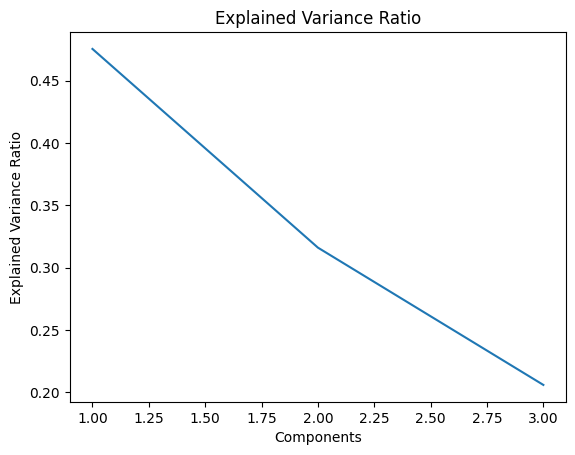

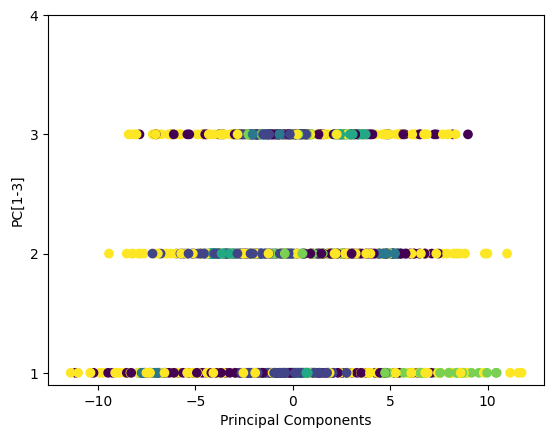

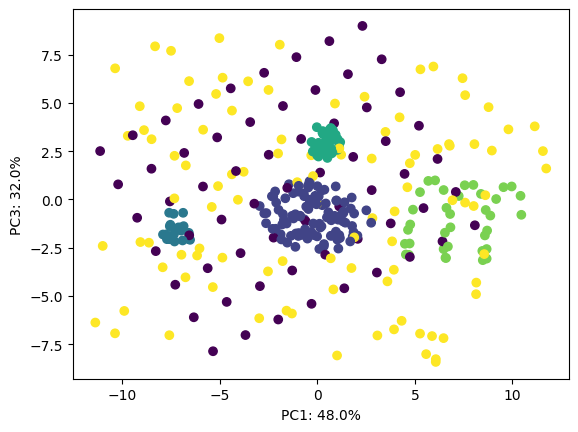

In [34]:
from sklearn.decomposition import PCA
# Part 2.a: Perform PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(x)

# Add the class information to the principal components
p_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
p_df['class'] = y

# Plot the explained variance ratio
x_modified = np.arange(1, 4, 1)
plt.plot(x_modified, pca.explained_variance_ratio_)
plt.xlabel('Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio')
plt.show()

# Plot the principal components
plt.scatter(p_df['PC1'], np.zeros(len(p_df))+1, c=p_df['class'])
plt.scatter(p_df['PC2'], np.zeros(len(p_df))+2, c=p_df['class'])
plt.scatter(p_df['PC3'], np.zeros(len(p_df))+3, c=p_df['class'])
plt.xlabel('Principal Components')
plt.ylabel('PC[1-3]')
plt.yticks(np.arange(1, 5, 1))
plt.show()

# Plot the first two principal components
plt.scatter(p_df['PC1'], p_df['PC3'], c=p_df['class'])
plt.xlabel('PC1: ' + str(round(pca.explained_variance_ratio_[0], 2) * 100)  + '%')
plt.ylabel('PC3: ' + str(round(pca.explained_variance_ratio_[1], 2) * 100) + '%')
plt.show()


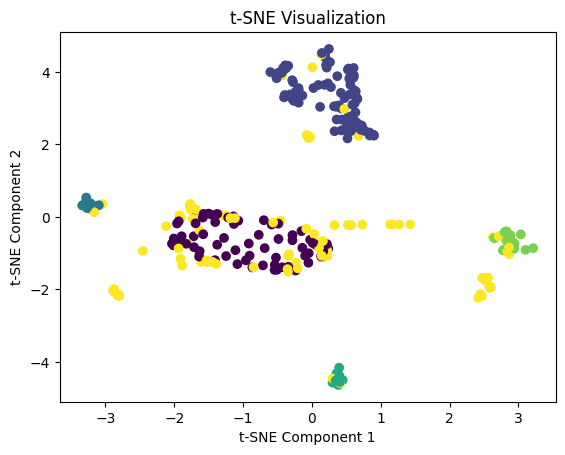

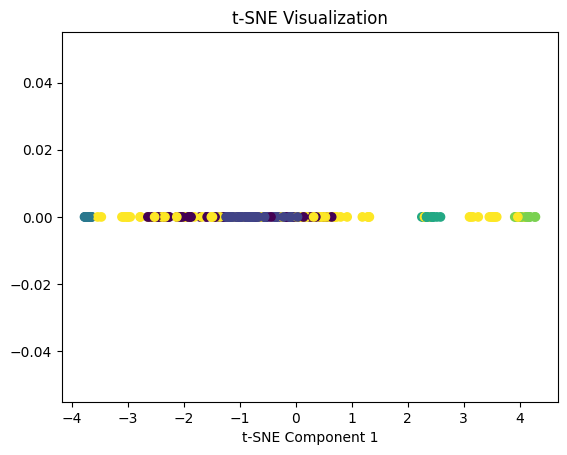

In [35]:
from sklearn.manifold import TSNE

# Create t-SNE object
tsne = TSNE(n_components=2, perplexity=4, n_iter=250, random_state=0)
# Apply t-SNE on the x values
x_tsne = tsne.fit_transform(x)

x_tsne_df = pd.DataFrame(data=x_tsne, columns=['tsne1', 'tsne2'])
x_tsne_df['class'] = y

# Plot the t-SNE results
plt.scatter(x_tsne_df['tsne1'], x_tsne_df['tsne2'], c=x_tsne_df['class'])
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization')
plt.show()

tsne = TSNE(n_components=1, perplexity=4, n_iter=250, random_state=0)
# Apply t-SNE on the x values
x_tsne = tsne.fit_transform(x)

x_tsne_df = pd.DataFrame(data=x_tsne, columns=['tsne1'])
x_tsne_df['class'] = y

# Plot the t-SNE results
plt.scatter(x_tsne_df['tsne1'],np.zeros(len(p_df)), c=x_tsne_df['class'])
plt.xlabel('t-SNE Component 1')
plt.title('t-SNE Visualization')
plt.show()

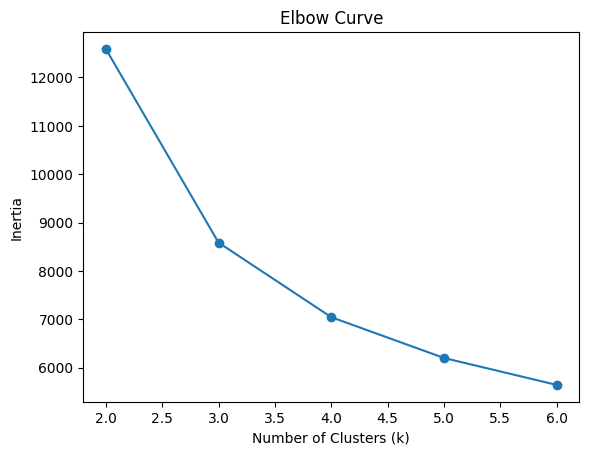

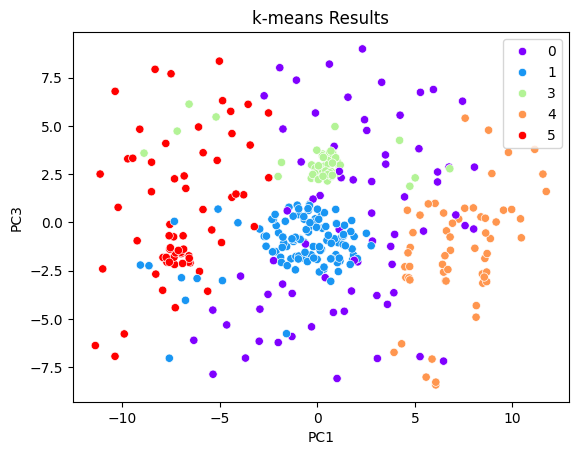

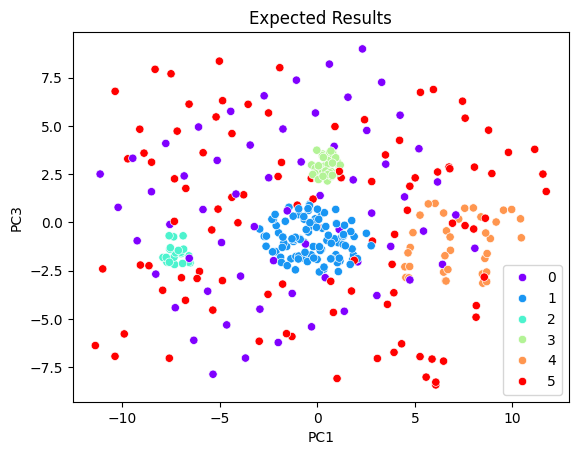

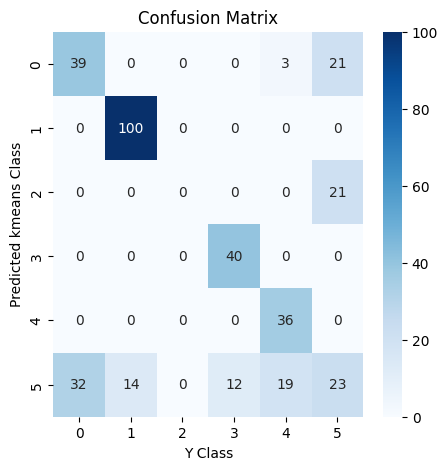

Homogeneity: 0.601
Completeness: 0.635
V-measure: 0.618
Accuracy score: 0.661


In [36]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics
import seaborn as sns


# Perform PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(x)
principal_components = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
# Apply k-means clustering for different values of k
k_values = range(2, y.iloc[:, 0].unique().size + 1)
inertia_values = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=1, max_iter=100)   
    kmeans.fit(principal_components)
    inertia_values.append(kmeans.inertia_)

# Plot the Elbow curve
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.show()

# Determine the optimal number of clusters using the Elbow method
optimal_k = 6

# Perform k-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', n_init=1, max_iter=100)
kmeans.fit_predict(principal_components)
predicted_labels = kmeans.labels_

# Map the predicted cluster labels to the actual labels
predicted_labels_mapped = plot_correlation_matrix(principal_components, predicted_labels, optimal_k)

# Plot the confusion matrix
confusion_mat = metrics.confusion_matrix(y, predicted_labels_mapped)
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_mat, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Y Class')
plt.ylabel('Predicted kmeans Class')
plt.title('Confusion Matrix')
plt.show()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(y.values.flatten(), predicted_labels_mapped))
print("Completeness: %0.3f" % metrics.completeness_score(y.values.flatten(), predicted_labels_mapped))
print("V-measure: %0.3f" % metrics.v_measure_score(y.values.flatten(), predicted_labels_mapped))
print("Accuracy score: %0.3f" % metrics.accuracy_score(y.values.flatten(), predicted_labels_mapped))


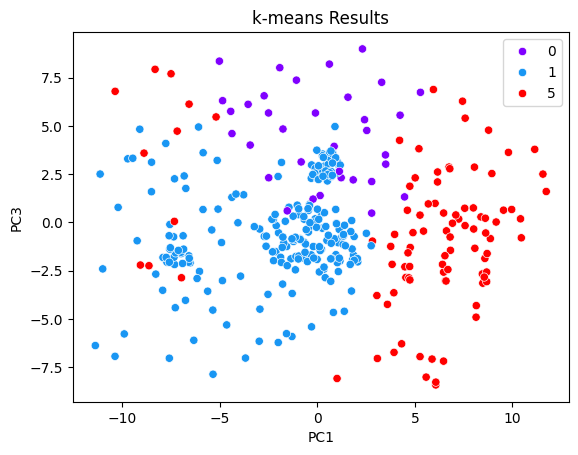

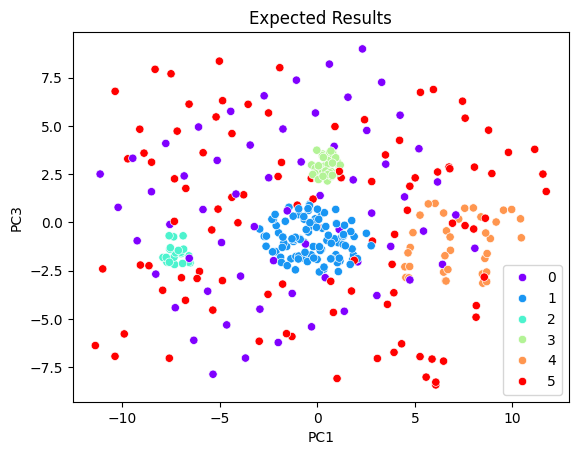

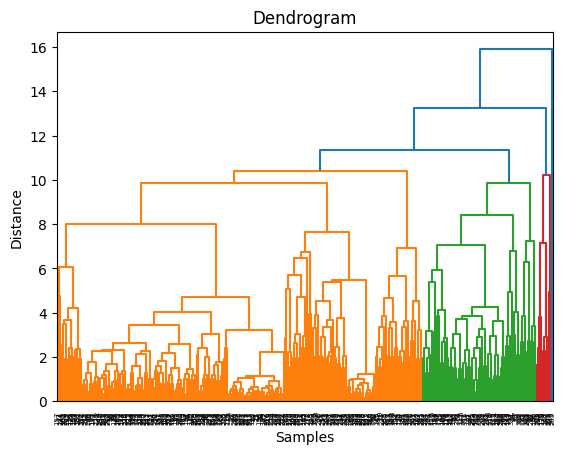

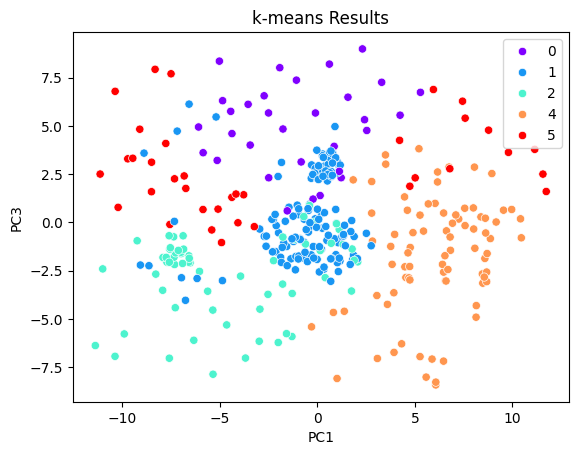

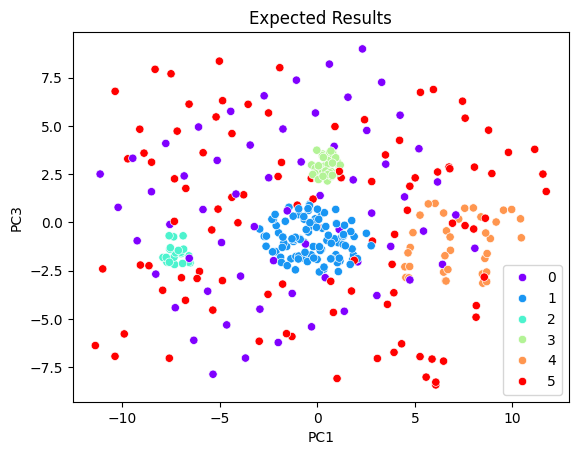

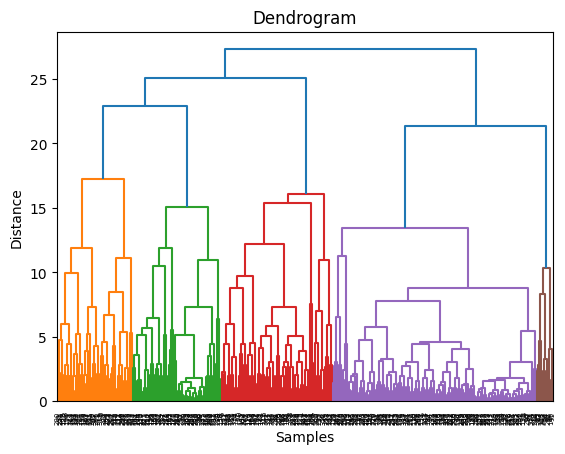

In [37]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage


pca = PCA(n_components=3)
principal_components = pca.fit_transform(x)
principal_components = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])

upgma = AgglomerativeClustering(n_clusters=6, linkage='average', metric='euclidean')
upgma_labels = upgma.fit_predict(principal_components)

plot_correlation_matrix(principal_components, upgma_labels, 6)

# Perform hierarchical clustering using the linkage function
linked_upgma = linkage(principal_components, method='average', metric='euclidean')

# Perform hierarchical clustering
dendrogram(linked_upgma, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

cl = AgglomerativeClustering(n_clusters=6, linkage='complete', metric='euclidean')
cl_labels = cl.fit_predict(principal_components)

plot_correlation_matrix(principal_components, cl_labels, 6)

# Perform hierarchical clustering using the linkage function
linked_cl = linkage(principal_components, method='complete', metric='euclidean')

# Perform hierarchical clustering
dendrogram(linked_cl, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()



Best performing parameter combination: 
Learning rate: 0.1
Neighborhood function: mexican_hat
Number of iterations: 500
SOM size: (10, 10)
Accuracy: 0.35555555555555557


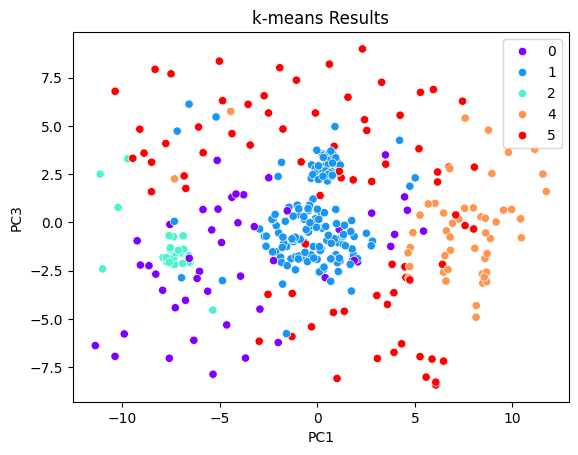

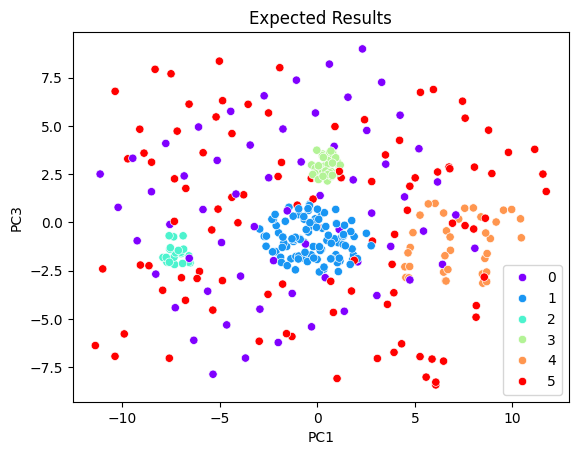

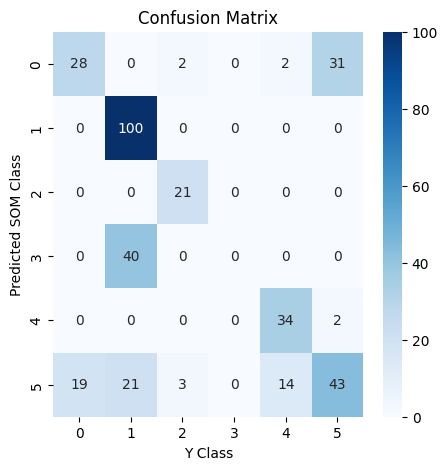

In [38]:
from sklearn import datasets
from minisom import MiniSom    
from sklearn.metrics import accuracy_score
from collections import Counter

# Define the parameter variations
learning_rates = [0.1, 0.5, 1.0]
neighborhood_functions = ['gaussian', 'mexican_hat']
som_sizes = [(10, 10), (15, 15), (20, 20)]
num_iterations = [100, 200, 500]
sigmas = [0.5, 1.0, 2.0]

accuracy = []
params = []
# Iterate over the parameter variations
for learning_rate in learning_rates:
    for neighborhood_function in neighborhood_functions:
        for num_iteration in num_iterations:
            for sigma in sigmas:
                for som_size in som_sizes:
                    # Perform PCA
                    pca = PCA(n_components=3)
                    principal_components = pca.fit_transform(x)
                    principal_components = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])

                    # Create the SOM object
                    som = MiniSom(som_size[0], som_size[1], 4, learning_rate=learning_rate, neighborhood_function=neighborhood_function, sigma=sigma)
                    som.train(x.values, num_iteration=num_iteration)
                    # Get the predicted labels from the SOM
                    predicted_labels = [som.winner(x.values[i])[1] for i in range(len(x.values))]
                    # Calculate the accuracy score
                    accuracy.append(accuracy_score(y, predicted_labels))
                    # Save the configuration params and the accuracy score in a list
                    params.append([learning_rate, neighborhood_function, num_iteration, som_size])

# Find the best performing parameter combination
best_params = params[np.argmax(accuracy)]
# Print the best performing parameter combination
print("Best performing parameter combination: ")
print("Learning rate: " + str(best_params[0]))
print("Neighborhood function: " + str(best_params[1]))
print("Number of iterations: " + str(best_params[2]))
print("SOM size: " + str(best_params[3]))
print("Accuracy: " + str(max(accuracy)))

som = MiniSom(best_params[3][0], best_params[3][1], 4, learning_rate=best_params[0], neighborhood_function=best_params[1])
som.train(x.values, num_iteration=best_params[2])
predicted_labels = [som.winner(x.values[i])[1] for i in range(len(x.values))]
#transform predicted_labels into array
predicted_labels = np.array(predicted_labels)

# Plot label predictions vs actual labels
predicted_labels_mapped = plot_correlation_matrix(principal_components, predicted_labels, best_params[3][0] * best_params[3][1])
                                                  
# Plot the confusion matrix
confusion_mat = metrics.confusion_matrix(y, predicted_labels_mapped)
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_mat, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Y Class')
plt.ylabel('Predicted SOM Class')
plt.title('Confusion Matrix')
plt.show()